# Machine Learning - Opções Binárias

## EUR/USD Put/Call Predictor

## Importações

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import pickle

# Correlação

Estarei utilizando a correlação e ativos para prever se a próxima vela será PUT ou CALL, abaixo temos uma lista de correlações positivas e negativas para o par EUR/USD no timeframe de 1 hora. Vou selecionar como correlação positiva o ouro (XAU/USD) e como correlação negativa o USD/CAD (por se tratar de uma major).

<div style="text-align:center;">
    <img src="img/correlation.png" width="750" height="750" />
</div>


## Estruturando e Visualizando os Dados

In [2]:
h = pd.read_csv('data/EURUSD_Candlestick_1_Hour_BID_03.05.2003-01.03.2024.csv')
o = pd.read_csv('data/XAUUSD_Candlestick_1_Hour_BID_03.05.2003-01.03.2024.csv')
g = pd.read_csv('data/USDCAD_Candlestick_1_Hour_BID_02.08.2003-01.03.2024.csv')

In [3]:
df1 = pd.DataFrame(h)
display(df1.head())
display(df1.tail())

,Gmt time,Open,High,Low,Close,Volume
0,04.05.2003 00:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0
1,04.05.2003 01:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0
2,04.05.2003 02:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0
3,04.05.2003 03:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0
4,04.05.2003 04:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0


,Gmt time,Open,High,Low,Close,Volume
182611,02.03.2024 19:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0
182612,02.03.2024 20:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0
182613,02.03.2024 21:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0
182614,02.03.2024 22:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0
182615,02.03.2024 23:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0


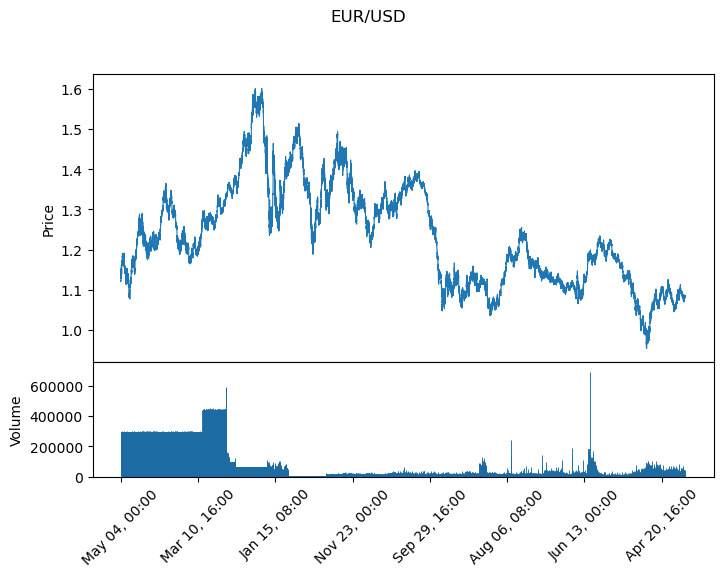

In [4]:
eur_usd = df1.copy()
eur_usd.index = pd.to_datetime(eur_usd['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')

eur_usd = eur_usd.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})

mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='line', volume=True, figratio=(12,8), figscale=1.0, style=s, title='EUR/USD', warn_too_much_data=10000000)

mpf.plot(eur_usd, **kwargs)

Vou adicionar o indicador das Bandas e Bollinger ao DataFrame para ser uma das entradas do modelo. As bandas de Bollinger é um indicador muito utilizado na operação de opções binárias.

In [5]:
period = 20

# Calcula a média móvel simples
df1['SMA'] = df1['Close'].rolling(window=period).mean()

# Calcula o desvio padrão
df1['STD'] = df1['Close'].rolling(window=period).std()

# Calcula a banda superior
df1['Upper'] = df1['SMA'] + (2 * df1['STD'])

# Calcula a banda inferior
df1['Lower'] = df1['SMA'] - (2 * df1['STD'])

display(df1.head())
display(df1.tail())

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower
0,04.05.2003 00:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN
1,04.05.2003 01:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN
2,04.05.2003 02:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN
3,04.05.2003 03:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN
4,04.05.2003 04:00:00.000,1.12284,1.12284,1.12284,1.12284,0.0,NaN,NaN,NaN,NaN


,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower
182611,02.03.2024 19:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368
182612,02.03.2024 20:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368
182613,02.03.2024 21:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368
182614,02.03.2024 22:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368
182615,02.03.2024 23:00:00.000,1.08368,1.08368,1.08368,1.08368,0.0,1.08368,0.0,1.08368,1.08368


In [6]:
# Dados do Ouro

df_gold = pd.DataFrame(o)
display(df_gold.head())
display(df_gold.tail())

,Gmt time,Open,High,Low,Close,Volume
0,04.05.2003 00:00:00.000,340.345,340.345,340.345,340.345,0.0
1,04.05.2003 01:00:00.000,340.345,340.345,340.345,340.345,0.0
2,04.05.2003 02:00:00.000,340.345,340.345,340.345,340.345,0.0
3,04.05.2003 03:00:00.000,340.345,340.345,340.345,340.345,0.0
4,04.05.2003 04:00:00.000,340.345,340.345,340.345,340.345,0.0


,Gmt time,Open,High,Low,Close,Volume
182611,02.03.2024 19:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0
182612,02.03.2024 20:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0
182613,02.03.2024 21:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0
182614,02.03.2024 22:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0
182615,02.03.2024 23:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0


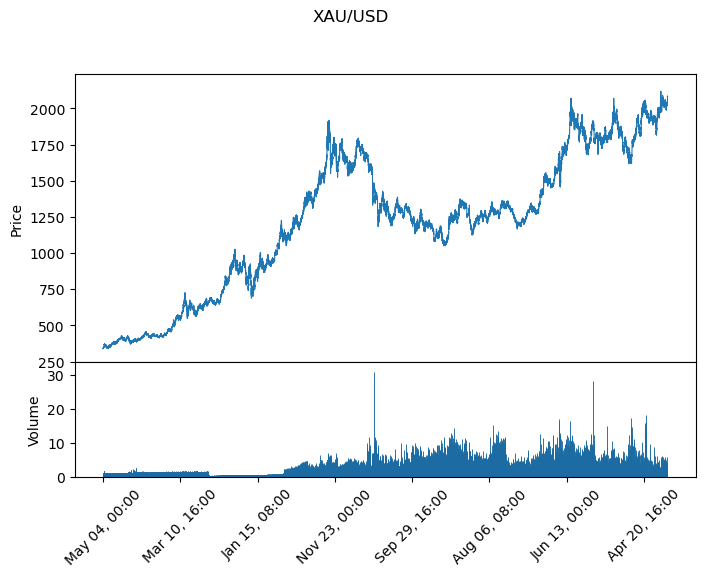

In [7]:
gold = df_gold.copy()
gold.index = pd.to_datetime(gold['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')

gold = gold.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})

mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='line', volume=True, figratio=(12,8), figscale=1.0, style=s, title='XAU/USD',warn_too_much_data=10000000)

mpf.plot(gold, **kwargs)

In [8]:
# Dados do USD/CAD
df_usdcad = pd.DataFrame(g)
display(df_usdcad.head())
display(df_usdcad.tail())

,Gmt time,Open,High,Low,Close,Volume
0,03.08.2003 00:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0
1,03.08.2003 01:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0
2,03.08.2003 02:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0
3,03.08.2003 03:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0
4,03.08.2003 04:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0


,Gmt time,Open,High,Low,Close,Volume
180427,02.03.2024 19:00:00.000,1.3558,1.3558,1.3558,1.3558,0.0
180428,02.03.2024 20:00:00.000,1.3558,1.3558,1.3558,1.3558,0.0
180429,02.03.2024 21:00:00.000,1.3558,1.3558,1.3558,1.3558,0.0
180430,02.03.2024 22:00:00.000,1.3558,1.3558,1.3558,1.3558,0.0
180431,02.03.2024 23:00:00.000,1.3558,1.3558,1.3558,1.3558,0.0


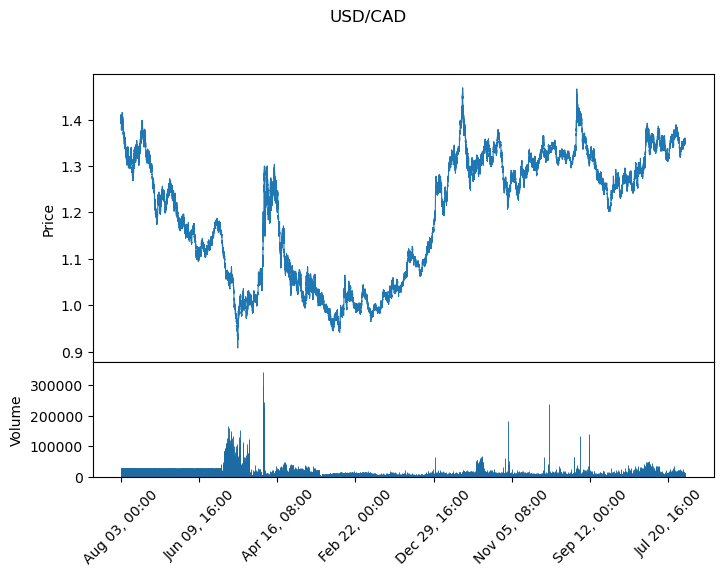

In [9]:
usd_cad = df_usdcad.copy()
usd_cad.index = pd.to_datetime(usd_cad['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')

usd_cad = usd_cad.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})

mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='line', volume=True, figratio=(12,8), figscale=1.0, style=s, title='USD/CAD',warn_too_much_data=10000000)

mpf.plot(usd_cad, **kwargs)

In [10]:
# Colocando a data como index
df1['datetime'] = pd.to_datetime(df1['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
df1 = df1.set_index(df1['datetime'])
df1.index.names = [None]
df1 = df1.drop(df1[df1['Volume'] == 0].index)
df1

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,datetime
2003-05-04 21:00:00,04.05.2003 21:00:00.000,1.12284,1.12338,1.12242,1.12305,29059.0996,1.122850,0.000047,1.122944,1.122757,2003-05-04 21:00:00
2003-05-04 22:00:00,04.05.2003 22:00:00.000,1.12274,1.12302,1.12226,1.12241,26091.8008,1.122829,0.000109,1.123047,1.122611,2003-05-04 22:00:00
2003-05-04 23:00:00,04.05.2003 23:00:00.000,1.12235,1.12235,1.12160,1.12169,29240.9004,1.122772,0.000277,1.123325,1.122218,2003-05-04 23:00:00
2003-05-05 00:00:00,05.05.2003 00:00:00.000,1.12161,1.12314,1.12154,1.12258,29914.8008,1.122759,0.000280,1.123318,1.122199,2003-05-05 00:00:00
2003-05-05 01:00:00,05.05.2003 01:00:00.000,1.12232,1.12262,1.12099,1.12140,28370.6992,1.122686,0.000412,1.123510,1.121863,2003-05-05 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 17:00:00,01.03.2024 17:00:00.000,1.08309,1.08398,1.08288,1.08376,4686.6400,1.081549,0.000963,1.083475,1.079623,2024-03-01 17:00:00
2024-03-01 18:00:00,01.03.2024 18:00:00.000,1.08376,1.08424,1.08315,1.08400,7922.0300,1.081725,0.001072,1.083870,1.079581,2024-03-01 18:00:00
2024-03-01 19:00:00,01.03.2024 19:00:00.000,1.08400,1.08432,1.08381,1.08412,6756.8000,1.081904,0.001160,1.084224,1.079584,2024-03-01 19:00:00
2024-03-01 20:00:00,01.03.2024 20:00:00.000,1.08412,1.08412,1.08348,1.08373,4078.8800,1.082034,0.001213,1.084460,1.079608,2024-03-01 20:00:00


In [11]:
df_gold['datetime'] = pd.to_datetime(df_gold['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
df_gold = df_gold.set_index(df_gold['datetime'])
df_gold.index.names = [None]
df_gold

,Gmt time,Open,High,Low,Close,Volume,datetime
2003-05-04 00:00:00,04.05.2003 00:00:00.000,340.345,340.345,340.345,340.345,0.0,2003-05-04 00:00:00
2003-05-04 01:00:00,04.05.2003 01:00:00.000,340.345,340.345,340.345,340.345,0.0,2003-05-04 01:00:00
2003-05-04 02:00:00,04.05.2003 02:00:00.000,340.345,340.345,340.345,340.345,0.0,2003-05-04 02:00:00
2003-05-04 03:00:00,04.05.2003 03:00:00.000,340.345,340.345,340.345,340.345,0.0,2003-05-04 03:00:00
2003-05-04 04:00:00,04.05.2003 04:00:00.000,340.345,340.345,340.345,340.345,0.0,2003-05-04 04:00:00
...,...,...,...,...,...,...,...
2024-03-02 19:00:00,02.03.2024 19:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0,2024-03-02 19:00:00
2024-03-02 20:00:00,02.03.2024 20:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0,2024-03-02 20:00:00
2024-03-02 21:00:00,02.03.2024 21:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0,2024-03-02 21:00:00
2024-03-02 22:00:00,02.03.2024 22:00:00.000,2082.395,2082.395,2082.395,2082.395,0.0,2024-03-02 22:00:00


In [12]:
df_usdcad['datetime'] = pd.to_datetime(df_usdcad['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
df_usdcad = df_usdcad.set_index(df_usdcad['datetime'])
df_usdcad.index.names = [None]
df_usdcad

,Gmt time,Open,High,Low,Close,Volume,datetime
2003-08-03 00:00:00,03.08.2003 00:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0,2003-08-03 00:00:00
2003-08-03 01:00:00,03.08.2003 01:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0,2003-08-03 01:00:00
2003-08-03 02:00:00,03.08.2003 02:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0,2003-08-03 02:00:00
2003-08-03 03:00:00,03.08.2003 03:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0,2003-08-03 03:00:00
2003-08-03 04:00:00,03.08.2003 04:00:00.000,1.39778,1.39778,1.39778,1.39778,0.0,2003-08-03 04:00:00
...,...,...,...,...,...,...,...
2024-03-02 19:00:00,02.03.2024 19:00:00.000,1.35580,1.35580,1.35580,1.35580,0.0,2024-03-02 19:00:00
2024-03-02 20:00:00,02.03.2024 20:00:00.000,1.35580,1.35580,1.35580,1.35580,0.0,2024-03-02 20:00:00
2024-03-02 21:00:00,02.03.2024 21:00:00.000,1.35580,1.35580,1.35580,1.35580,0.0,2024-03-02 21:00:00
2024-03-02 22:00:00,02.03.2024 22:00:00.000,1.35580,1.35580,1.35580,1.35580,0.0,2024-03-02 22:00:00


In [13]:
df_gold = df_gold.loc[:,['Open', 'High', 'Low', 'Close', 'Volume']]

df_gold = df_gold.rename(columns={'Open': 'Open_gold', 'High': 'High_gold', 'Low':'Low_gold', 'Close':'Close_gold', 'Volume':'Volume_gold'})
df_gold = df_gold.drop(df_gold[df_gold['Volume_gold'] == 0].index)
df_gold.tail()

,Open_gold,High_gold,Low_gold,Close_gold,Volume_gold
2024-03-01 17:00:00,2080.875,2085.605,2079.925,2084.725,2.3546
2024-03-01 18:00:00,2084.715,2088.215,2082.105,2085.595,2.3747
2024-03-01 19:00:00,2085.615,2086.615,2084.598,2085.148,1.6788
2024-03-01 20:00:00,2085.125,2085.198,2082.955,2083.375,0.8636
2024-03-01 21:00:00,2083.375,2083.898,2082.345,2082.395,0.4415


In [14]:
df_usdcad = df_usdcad.loc[:,['Open', 'High', 'Low', 'Close', 'Volume']]

df_usdcad = df_usdcad.rename(columns={'Open': 'Open_usdcad', 'High': 'High_usdcad', 'Low':'Low_usdcad', 'Close':'Close_usdcad', 'Volume':'Volume_usdcad'})
df_usdcad = df_usdcad.drop(df_usdcad[df_usdcad['Volume_usdcad'] == 0].index)
df_usdcad.tail()

,Open_usdcad,High_usdcad,Low_usdcad,Close_usdcad,Volume_usdcad
2024-03-01 17:00:00,1.35548,1.35552,1.35448,1.35535,4740.69
2024-03-01 18:00:00,1.35534,1.35615,1.35533,1.35562,5225.66
2024-03-01 19:00:00,1.35559,1.35600,1.35517,1.35586,4752.70
2024-03-01 20:00:00,1.35587,1.35620,1.35573,1.35580,2787.66
2024-03-01 21:00:00,1.35581,1.35612,1.35571,1.35580,2153.18


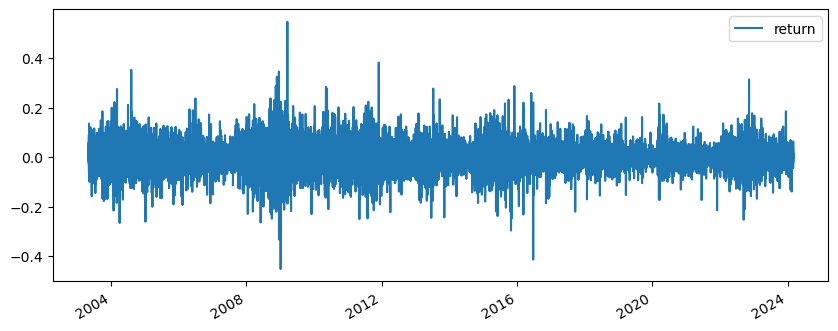

0.05522000000000005

In [16]:
# Retorno (close-open) normalizado

df1['return_next'] = df1['Close'].shift(-1) - df1['Open'].shift(-1)
return_range = df1['return_next'].max() - df1['return_next'].min()
df1['return_next'] = df1['return_next'] / return_range

df1['return'] = df1['Close'] - df1['Open']
return_range = df1['return'].max() - df1['return'].min()
df1['return'] = df1['return'] / return_range

df1.plot(y='return', figsize=(10,4))

plt.show()

df1['return'].min()
return_range

In [18]:
# label 1 CALL, label 0 PUT
# ****************** consider when return ==0 next version

df1['label'] = df1['return_next'].apply(lambda x: 1 if x>0 else 0)
df1.tail(10)

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,datetime,return_next,return,label
2024-03-01 12:00:00,01.03.2024 12:00:00.000,1.08187,1.08247,1.08119,1.08129,12278.43,1.081090,0.000565,1.082219,1.079960,2024-03-01 12:00:00,-0.000181,-0.010503,0
2024-03-01 13:00:00,01.03.2024 13:00:00.000,1.08128,1.08153,1.08078,1.08127,13035.98,1.081154,0.000501,1.082157,1.080151,2024-03-01 13:00:00,-0.023180,-0.000181,0
2024-03-01 14:00:00,01.03.2024 14:00:00.000,1.08127,1.08206,1.07981,1.07999,16308.84,1.081108,0.000563,1.082235,1.079981,2024-03-01 14:00:00,0.063383,-0.023180,1
2024-03-01 15:00:00,01.03.2024 15:00:00.000,1.08000,1.08416,1.08000,1.08350,45959.82,1.081271,0.000743,1.082756,1.079785,2024-03-01 15:00:00,-0.007063,0.063383,0
2024-03-01 16:00:00,01.03.2024 16:00:00.000,1.08349,1.08368,1.08233,1.08310,9435.35,1.081384,0.000839,1.083062,1.079706,2024-03-01 16:00:00,0.012133,-0.007063,1
2024-03-01 17:00:00,01.03.2024 17:00:00.000,1.08309,1.08398,1.08288,1.08376,4686.64,1.081549,0.000963,1.083475,1.079623,2024-03-01 17:00:00,0.004346,0.012133,1
2024-03-01 18:00:00,01.03.2024 18:00:00.000,1.08376,1.08424,1.08315,1.08400,7922.03,1.081725,0.001072,1.083870,1.079581,2024-03-01 18:00:00,0.002173,0.004346,1
2024-03-01 19:00:00,01.03.2024 19:00:00.000,1.08400,1.08432,1.08381,1.08412,6756.80,1.081904,0.001160,1.084224,1.079584,2024-03-01 19:00:00,-0.007063,0.002173,0
2024-03-01 20:00:00,01.03.2024 20:00:00.000,1.08412,1.08412,1.08348,1.08373,4078.88,1.082034,0.001213,1.084460,1.079608,2024-03-01 20:00:00,-0.000905,-0.007063,0
2024-03-01 21:00:00,01.03.2024 21:00:00.000,1.08373,1.08405,1.08333,1.08368,5821.63,1.082112,0.001268,1.084648,1.079576,2024-03-01 21:00:00,NaN,-0.000905,0


In [20]:
# The last register shows a NaN

df1.dropna(inplace=True)

df1.tail()

,Gmt time,Open,High,Low,Close,Volume,SMA,STD,Upper,Lower,datetime,return_next,return,label
2024-03-01 16:00:00,01.03.2024 16:00:00.000,1.08349,1.08368,1.08233,1.08310,9435.35,1.081384,0.000839,1.083062,1.079706,2024-03-01 16:00:00,0.012133,-0.007063,1
2024-03-01 17:00:00,01.03.2024 17:00:00.000,1.08309,1.08398,1.08288,1.08376,4686.64,1.081549,0.000963,1.083475,1.079623,2024-03-01 17:00:00,0.004346,0.012133,1
2024-03-01 18:00:00,01.03.2024 18:00:00.000,1.08376,1.08424,1.08315,1.08400,7922.03,1.081725,0.001072,1.083870,1.079581,2024-03-01 18:00:00,0.002173,0.004346,1
2024-03-01 19:00:00,01.03.2024 19:00:00.000,1.08400,1.08432,1.08381,1.08412,6756.80,1.081904,0.001160,1.084224,1.079584,2024-03-01 19:00:00,-0.007063,0.002173,0
2024-03-01 20:00:00,01.03.2024 20:00:00.000,1.08412,1.08412,1.08348,1.08373,4078.88,1.082034,0.001213,1.084460,1.079608,2024-03-01 20:00:00,-0.000905,-0.007063,0


In [22]:
df1 = df1.loc[:,['Open', 'High', 'Low', 'Close', 'Volume','SMA','Upper','Lower', 'label']]
df1.tail()

,Open,High,Low,Close,Volume,SMA,Upper,Lower,label
2024-03-01 16:00:00,1.08349,1.08368,1.08233,1.08310,9435.35,1.081384,1.083062,1.079706,1
2024-03-01 17:00:00,1.08309,1.08398,1.08288,1.08376,4686.64,1.081549,1.083475,1.079623,1
2024-03-01 18:00:00,1.08376,1.08424,1.08315,1.08400,7922.03,1.081725,1.083870,1.079581,1
2024-03-01 19:00:00,1.08400,1.08432,1.08381,1.08412,6756.80,1.081904,1.084224,1.079584,0
2024-03-01 20:00:00,1.08412,1.08412,1.08348,1.08373,4078.88,1.082034,1.084460,1.079608,0


In [24]:
df = pd.concat([df1,df_gold],axis=1, join='inner')
df.head()

,Open,High,Low,Close,Volume,SMA,Upper,Lower,label,Open_gold,High_gold,Low_gold,Close_gold,Volume_gold
2003-05-05 00:00:00,1.12161,1.12314,1.12154,1.12258,29914.8008,1.122759,1.123318,1.122199,0,340.345,340.843,339.810,340.036,0.0804
2003-05-05 01:00:00,1.12232,1.12262,1.12099,1.12140,28370.6992,1.122686,1.123510,1.121863,1,340.461,341.255,339.955,339.987,0.0671
2003-05-05 02:00:00,1.12141,1.12211,1.12085,1.12152,29867.6992,1.122621,1.123591,1.121650,1,340.134,340.472,339.813,339.989,0.0482
2003-05-05 03:00:00,1.12123,1.12179,1.12049,1.12162,27256.8008,1.122559,1.123621,1.121498,1,340.347,340.549,339.842,340.009,0.0888
2003-05-05 04:00:00,1.12098,1.12176,1.12079,1.12122,28278.9004,1.122479,1.123687,1.121270,1,340.221,340.604,339.734,340.231,0.1032


In [25]:
df = pd.concat([df,df_usdcad],axis=1, join='inner')
df.head()

,Open,High,Low,Close,Volume,SMA,Upper,Lower,label,Open_gold,High_gold,Low_gold,Close_gold,Volume_gold,Open_usdcad,High_usdcad,Low_usdcad,Close_usdcad,Volume_usdcad
2003-08-03 21:00:00,1.12773,1.12851,1.12746,1.12769,30024.1992,1.125429,1.126493,1.124365,1,348.095,348.098,347.592,347.826,0.0266,1.39778,1.39838,1.39756,1.39775,4346.8999
2003-08-03 22:00:00,1.12781,1.12827,1.12696,1.12791,26939.8008,1.125559,1.127093,1.124025,0,348.095,348.135,347.576,347.747,0.0327,1.39790,1.39955,1.39777,1.39876,4602.0000
2003-08-03 23:00:00,1.12773,1.12793,1.12630,1.12678,28072.6992,1.125633,1.127255,1.124010,0,347.912,348.135,346.940,347.495,0.0545,1.39894,1.40101,1.39894,1.40036,2926.8000
2003-08-04 00:00:00,1.12672,1.12761,1.12608,1.12645,29135.0996,1.125690,1.127344,1.124035,0,347.708,349.592,347.708,348.512,0.0602,1.40029,1.40072,1.39932,1.39990,3099.3999
2003-08-04 01:00:00,1.12643,1.12675,1.12572,1.12623,31069.0996,1.125736,1.127397,1.124074,0,348.717,349.349,348.552,348.795,0.0601,1.40000,1.40036,1.39912,1.39967,3266.7000


In [27]:
df.dtypes

Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
SMA              float64
Upper            float64
Lower            float64
label              int64
Open_gold        float64
High_gold        float64
Low_gold         float64
Close_gold       float64
Volume_gold      float64
Open_usdcad      float64
High_usdcad      float64
Low_usdcad       float64
Close_usdcad     float64
Volume_usdcad    float64
dtype: object

## Gerando datasets de treino e teste

In [31]:
# Normalizando dados
from sklearn.preprocessing import StandardScaler

# Selecionando todas as colunas exceto a label
features = df.drop(columns=['label'])

# Normalizando as features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Criando um novo DataFrame com as features normalizadas
df_normalized = pd.DataFrame(normalized_features, columns=features.columns, index=df.index)

# Adicionando a coluna label ao DataFrame normalizado
df_normalized['label'] = df['label']

# Exibindo o DataFrame normalizado
df_normalized

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Open_gold,High_gold,Low_gold,Close_gold,Volume_gold,Open_usdcad,High_usdcad,Low_usdcad,Close_usdcad,Volume_usdcad,label
2003-08-03 21:00:00,-0.858721,-0.859313,-0.854320,-0.859039,0.207729,-0.876917,-0.896122,-0.856974,-1.854835,-1.856586,-1.854100,-1.855489,-0.987499,1.525843,1.522738,1.531897,1.525655,-0.282560,1
2003-08-03 22:00:00,-0.858093,-0.861194,-0.858250,-0.857312,0.125281,-0.875897,-0.891440,-0.859657,-1.854835,-1.856507,-1.854134,-1.855656,-0.983648,1.526744,1.531513,1.533473,1.533232,-0.254788,0
2003-08-03 23:00:00,-0.858721,-0.863858,-0.863436,-0.866180,0.155564,-0.875320,-0.890179,-0.859772,-1.855224,-1.856507,-1.855488,-1.856192,-0.969886,1.534546,1.542462,1.542254,1.545236,-0.437163,0
2003-08-04 00:00:00,-0.866646,-0.866366,-0.865165,-0.868769,0.183963,-0.874873,-0.889484,-0.859576,-1.855658,-1.853414,-1.853854,-1.854031,-0.966287,1.544674,1.540287,1.545106,1.541785,-0.418372,0
2003-08-04 01:00:00,-0.868922,-0.873105,-0.867995,-0.870495,0.235660,-0.874512,-0.889073,-0.859266,-1.853513,-1.853930,-1.852058,-1.853429,-0.966350,1.542498,1.537587,1.543605,1.540059,-0.400159,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 16:00:00,-1.205880,-1.210622,-1.208993,-1.208939,-0.342628,-1.222588,-1.235009,-1.209297,1.802788,1.824572,1.808336,1.828251,1.535618,1.206247,1.205960,1.208435,1.208531,0.037992,1
2024-03-01 17:00:00,-1.209019,-1.208271,-1.204670,-1.203760,-0.469565,-1.221293,-1.231786,-1.209952,1.827890,1.832513,1.831443,1.836072,0.482168,1.208498,1.201310,1.208585,1.207556,-0.239689,1
2024-03-01 18:00:00,-1.203761,-1.206234,-1.202549,-1.201877,-0.383080,-1.219908,-1.228706,-1.210281,1.836051,1.838055,1.836080,1.837921,0.494857,1.207448,1.206035,1.214964,1.209581,-0.186892,1
2024-03-01 19:00:00,-1.201878,-1.205607,-1.197362,-1.200935,-0.414228,-1.218507,-1.225946,-1.210255,1.837964,1.834658,1.841384,1.836971,0.055535,1.209323,1.204910,1.213763,1.211382,-0.238382,0


In [32]:
# Teste
df_test = df_normalized.loc['2023-01-01':,:]  
display(df_test.head())
display(df_test.tail())

# Treino
df_train = df_normalized.loc[:'2022-12-31',:] 
display(df_train.head())
display(df_train.tail())

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Open_gold,High_gold,Low_gold,Close_gold,Volume_gold,Open_usdcad,High_usdcad,Low_usdcad,Close_usdcad,Volume_usdcad,label
2023-01-02 23:00:00,-1.339047,-1.330912,-1.345266,-1.330177,-0.165643,-1.332772,-1.336404,-1.328300,1.287976,1.289720,1.285445,1.293188,0.037732,1.217951,1.210535,1.213913,1.214458,-0.249235,0
2023-01-03 00:00:00,-1.330258,-1.334830,-1.332142,-1.334963,-0.265212,-1.333906,-1.339763,-1.327184,1.293179,1.294278,1.296971,1.295866,-0.427220,1.214575,1.215409,1.217516,1.222560,-0.189615,0
2023-01-03 01:00:00,-1.335045,-1.338121,-1.344952,-1.343360,-0.011654,-1.335244,-1.342428,-1.327180,1.295899,1.294703,1.292674,1.291339,-0.003618,1.222527,1.248707,1.230124,1.249869,0.249586,1
2023-01-03 02:00:00,-1.343363,-1.335379,-1.339294,-1.330334,-0.247114,-1.335758,-1.344208,-1.326414,1.291394,1.310755,1.295929,1.312210,-0.144082,1.249685,1.248932,1.231175,1.223836,0.192505,0
2023-01-03 03:00:00,-1.330336,-1.334830,-1.330413,-1.333551,-0.341446,-1.336009,-1.344756,-1.326364,1.312179,1.317528,1.317225,1.318310,-0.390983,1.223728,1.216234,1.205508,1.199078,-0.148673,0


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Open_gold,High_gold,Low_gold,Close_gold,Volume_gold,Open_usdcad,High_usdcad,Low_usdcad,Close_usdcad,Volume_usdcad,label
2024-03-01 16:00:00,-1.205880,-1.210622,-1.208993,-1.208939,-0.342628,-1.222588,-1.235009,-1.209297,1.802788,1.824572,1.808336,1.828251,1.535618,1.206247,1.205960,1.208435,1.208531,0.037992,1
2024-03-01 17:00:00,-1.209019,-1.208271,-1.204670,-1.203760,-0.469565,-1.221293,-1.231786,-1.209952,1.827890,1.832513,1.831443,1.836072,0.482168,1.208498,1.201310,1.208585,1.207556,-0.239689,1
2024-03-01 18:00:00,-1.203761,-1.206234,-1.202549,-1.201877,-0.383080,-1.219908,-1.228706,-1.210281,1.836051,1.838055,1.836080,1.837921,0.494857,1.207448,1.206035,1.214964,1.209581,-0.186892,1
2024-03-01 19:00:00,-1.201878,-1.205607,-1.197362,-1.200935,-0.414228,-1.218507,-1.225946,-1.210255,1.837964,1.834658,1.841384,1.836971,0.055535,1.209323,1.204910,1.213763,1.211382,-0.238382,0
2024-03-01 20:00:00,-1.200936,-1.207174,-1.199955,-1.203996,-0.485811,-1.217487,-1.224102,-1.210068,1.836923,1.831649,1.837889,1.833203,-0.459101,1.211424,1.206410,1.217966,1.210932,-0.452311,0


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Open_gold,High_gold,Low_gold,Close_gold,Volume_gold,Open_usdcad,High_usdcad,Low_usdcad,Close_usdcad,Volume_usdcad,label
2003-08-03 21:00:00,-0.858721,-0.859313,-0.854320,-0.859039,0.207729,-0.876917,-0.896122,-0.856974,-1.854835,-1.856586,-1.854100,-1.855489,-0.987499,1.525843,1.522738,1.531897,1.525655,-0.282560,1
2003-08-03 22:00:00,-0.858093,-0.861194,-0.858250,-0.857312,0.125281,-0.875897,-0.891440,-0.859657,-1.854835,-1.856507,-1.854134,-1.855656,-0.983648,1.526744,1.531513,1.533473,1.533232,-0.254788,0
2003-08-03 23:00:00,-0.858721,-0.863858,-0.863436,-0.866180,0.155564,-0.875320,-0.890179,-0.859772,-1.855224,-1.856507,-1.855488,-1.856192,-0.969886,1.534546,1.542462,1.542254,1.545236,-0.437163,0
2003-08-04 00:00:00,-0.866646,-0.866366,-0.865165,-0.868769,0.183963,-0.874873,-0.889484,-0.859576,-1.855658,-1.853414,-1.853854,-1.854031,-0.966287,1.544674,1.540287,1.545106,1.541785,-0.418372,0
2003-08-04 01:00:00,-0.868922,-0.873105,-0.867995,-0.870495,0.235660,-0.874512,-0.889073,-0.859266,-1.853513,-1.853930,-1.852058,-1.853429,-0.966350,1.542498,1.537587,1.543605,1.540059,-0.400159,0


,Open,High,Low,Close,Volume,SMA,Upper,Lower,Open_gold,High_gold,Low_gold,Close_gold,Volume_gold,Open_usdcad,High_usdcad,Low_usdcad,Close_usdcad,Volume_usdcad,label
2022-12-30 17:00:00,-1.314328,-1.308891,-1.308958,-1.303261,0.091568,-1.337877,-1.336602,-1.338364,1.265086,1.276847,1.270044,1.281434,1.743063,1.190943,1.192761,1.194776,1.189550,0.099726,0
2022-12-30 18:00:00,-1.303028,-1.307559,-1.305657,-1.310010,0.372112,-1.336233,-1.332370,-1.339337,1.281664,1.281055,1.275892,1.271343,2.637931,1.189442,1.199960,1.195676,1.207106,0.913733,0
2022-12-30 19:00:00,-1.310012,-1.310537,-1.309823,-1.312050,-0.004596,-1.334683,-1.329146,-1.339480,1.271422,1.274240,1.275041,1.276722,0.960567,1.206697,1.210610,1.199504,1.192701,0.336890,1
2022-12-30 20:00:00,-1.312052,-1.311399,-1.312102,-1.307656,-0.255092,-1.333227,-1.325479,-1.340261,1.276735,1.277172,1.281107,1.280463,0.025548,1.192593,1.190811,1.193575,1.196377,0.220588,0
2022-12-30 21:00:00,-1.307266,-1.312261,-1.307386,-1.309696,-0.311022,-1.331571,-1.322599,-1.339844,1.280831,1.278148,1.284425,1.280792,-0.766481,1.196419,1.197636,1.200479,1.201929,-0.468229,0


In [33]:
df_train.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'Upper', 'Lower',
       'Open_gold', 'High_gold', 'Low_gold', 'Close_gold', 'Volume_gold',
       'Open_usdcad', 'High_usdcad', 'Low_usdcad', 'Close_usdcad',
       'Volume_usdcad', 'label'],
      dtype='object')

## Treinando o Modelo

In [34]:
# Separate features and output

y_train = df_train['label']
X_train = df_train.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'Upper', 'Lower',
       'Open_gold', 'High_gold', 'Low_gold', 'Close_gold', 'Volume_gold',
       'Open_usdcad', 'High_usdcad', 'Low_usdcad', 'Close_usdcad',
       'Volume_usdcad']]

y_test = df_test['label']
X_test = df_test.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'Upper', 'Lower',
       'Open_gold', 'High_gold', 'Low_gold', 'Close_gold', 'Volume_gold',
       'Open_usdcad', 'High_usdcad', 'Low_usdcad', 'Close_usdcad',
       'Volume_usdcad']]


In [35]:
print(X_test.shape)
print(y_test.shape)

print('%% of Class0 : %f y_test' % (np.count_nonzero(y_test == 0)/float(len(y_test))))
print('%% of Class1 : %f y_test' % (np.count_nonzero(y_test == 1)/float(len(y_test))))

(6897, 18)
(6897,)
% of Class0 : 0.503842 y_test
% of Class1 : 0.496158 y_test


In [36]:
print(X_train.shape)
print(y_train.shape)

print('%% of Class0 : %f y_train' % (np.count_nonzero(y_train == 0)/float(len(y_train))))
print('%% of Class1 : %f y_train' % (np.count_nonzero(y_train == 1)/float(len(y_train))))

(118325, 18)
(118325,)
% of Class0 : 0.500368 y_train
% of Class1 : 0.499632 y_train


In [37]:
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=1000, verbose=3)

scores = cross_val_score(clf, X_train, y_train, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3862           11.42m
         2           1.3862           12.42m
         3           1.3861           11.65m
         4           1.3860           12.07m
         5           1.3860           11.70m
         6           1.3859           11.80m
         7           1.3858           11.74m
         8           1.3858           11.53m
         9           1.3857           11.73m
        10           1.3857           11.55m
        11           1.3856           11.60m
        12           1.3855           11.57m
        13           1.3855           11.46m
        14           1.3854           11.61m
        15           1.3854           11.54m
        16           1.3853           11.61m
        17           1.3853           11.64m
        18           1.3852           11.58m
        19           1.3852           11.63m
        20           1.3851           11.61m
        21           1.3851           11.54m
        2

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=0, verbose=3)

## Testando o Model

In [48]:
accuracy = clf.score(X_train, y_train)
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.533159


In [49]:
pred = clf.predict(X_test)

In [50]:
df_trade = pd.DataFrame(X_test)
df_trade['label']  = y_test
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']

df_trade

,Open,High,Low,Close,Volume,SMA,Upper,Lower,Open_gold,High_gold,...,Close_gold,Volume_gold,Open_usdcad,High_usdcad,Low_usdcad,Close_usdcad,Volume_usdcad,label,pred,won
2023-01-02 23:00:00,-1.339047,-1.330912,-1.345266,-1.330177,-0.165643,-1.332772,-1.336404,-1.328300,1.287976,1.289720,...,1.293188,0.037732,1.217951,1.210535,1.213913,1.214458,-0.249235,0,0,True
2023-01-03 00:00:00,-1.330258,-1.334830,-1.332142,-1.334963,-0.265212,-1.333906,-1.339763,-1.327184,1.293179,1.294278,...,1.295866,-0.427220,1.214575,1.215409,1.217516,1.222560,-0.189615,0,0,True
2023-01-03 01:00:00,-1.335045,-1.338121,-1.344952,-1.343360,-0.011654,-1.335244,-1.342428,-1.327180,1.295899,1.294703,...,1.291339,-0.003618,1.222527,1.248707,1.230124,1.249869,0.249586,1,0,False
2023-01-03 02:00:00,-1.343363,-1.335379,-1.339294,-1.330334,-0.247114,-1.335758,-1.344208,-1.326414,1.291394,1.310755,...,1.312210,-0.144082,1.249685,1.248932,1.231175,1.223836,0.192505,0,0,True
2023-01-03 03:00:00,-1.330336,-1.334830,-1.330413,-1.333551,-0.341446,-1.336009,-1.344756,-1.326364,1.312179,1.317528,...,1.318310,-0.390983,1.223728,1.216234,1.205508,1.199078,-0.148673,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 16:00:00,-1.205880,-1.210622,-1.208993,-1.208939,-0.342628,-1.222588,-1.235009,-1.209297,1.802788,1.824572,...,1.828251,1.535618,1.206247,1.205960,1.208435,1.208531,0.037992,1,1,True
2024-03-01 17:00:00,-1.209019,-1.208271,-1.204670,-1.203760,-0.469565,-1.221293,-1.231786,-1.209952,1.827890,1.832513,...,1.836072,0.482168,1.208498,1.201310,1.208585,1.207556,-0.239689,1,1,True
2024-03-01 18:00:00,-1.203761,-1.206234,-1.202549,-1.201877,-0.383080,-1.219908,-1.228706,-1.210281,1.836051,1.838055,...,1.837921,0.494857,1.207448,1.206035,1.214964,1.209581,-0.186892,1,1,True
2024-03-01 19:00:00,-1.201878,-1.205607,-1.197362,-1.200935,-0.414228,-1.218507,-1.225946,-1.210255,1.837964,1.834658,...,1.836971,0.055535,1.209323,1.204910,1.213763,1.211382,-0.238382,0,1,False


In [51]:
# Win/Loss

print(df_trade[df_trade['won'] == False]['won'].count())
print(df_trade[df_trade['won'] == True]['won'].count())

3410
3487


In [52]:
# % Win

won_percentage = df_trade[df_trade['won'] == True]['won'].count()*100/df_trade['won'].count()
print("Percentual dos Trades acertados: {:.2f}%".format(won_percentage))

Percentual dos Trades acertados: 50.56%


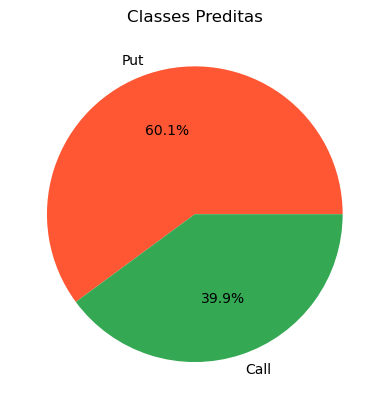

In [53]:
# Total de classes preditas

counts = df_trade['pred'].value_counts()
labels = ['Put', 'Call']
colors = ['#FF5733', '#34A853']
plt.pie(counts, labels=labels, colors = colors, autopct='%1.1f%%')
plt.title('Classes Preditas')
plt.show()

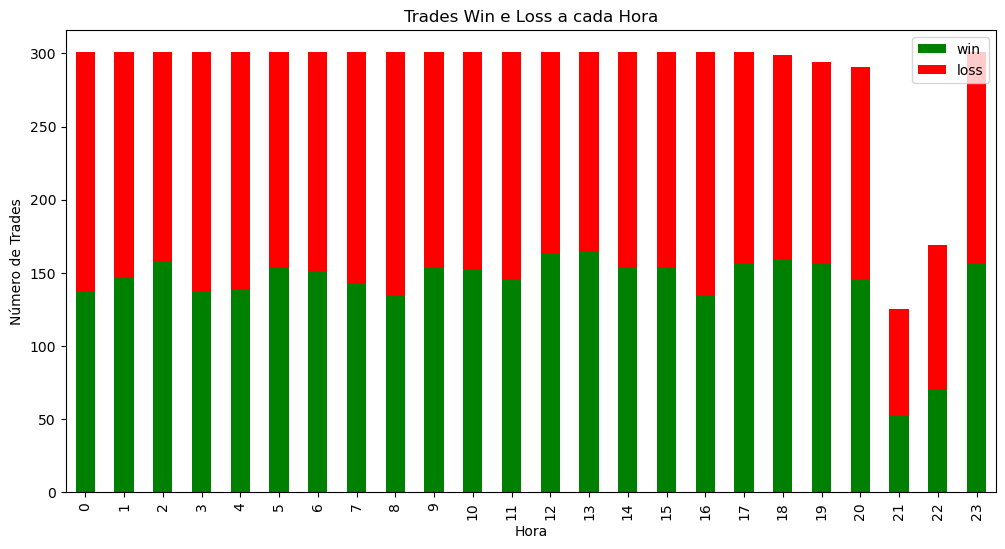

In [54]:
df_trade.index = pd.to_datetime(df_trade.index)

df_trade['hour'] = df_trade.index.hour

df_hour = df_trade.groupby(['hour', 'won'])['won'].count().unstack()

df_hour.columns = ['win', 'loss']

ax = df_hour.plot(kind='bar', stacked=True, figsize=(12,6), color=['green', 'red'])

ax.set_xlabel('Hora')
ax.set_ylabel('Número de Trades')
ax.set_title('Trades Win e Loss a cada Hora')

plt.show()

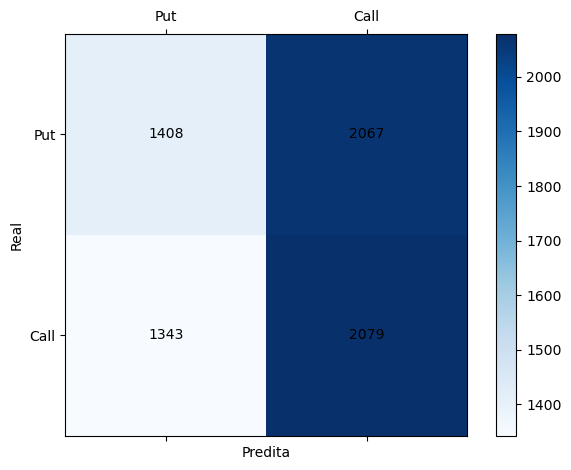

In [55]:
cm = confusion_matrix(y_test, pred)

class_names = ['Put', 'Call']

fig, ax = plt.subplots()
im = ax.matshow(cm, cmap=plt.cm.Blues)

cbar = ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       xlabel='Predita', ylabel='Real')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.tight_layout()

plt.show()

In [56]:
# Salvando modelo
with open('eurusd.pkl', 'wb') as f:
    pickle.dump(clf, f)